# Exploration des données et sélections de variables

La **morue de l’Atlantique (Gadus morhua)** est l’une des espèces les plus emblématiques des pêches nordiques. Autrefois, abondante dans tout l’Atlantique Nord, elle a subi un effondrement majeur à partir des années 1980-90, notamment dans les eaux canadiennes, à cause de la surpêche et de la dégradation de son habitat. Aujourd’hui, certaines populations se reconstituent, d’autres restent fragiles, et sa distribution tend à se déplacer vers le nord sous l’effet du changement climatique.

Ce projet a pour but de **prédire la présence de la morue à partir de variables environnementales (température, chlorophylle, salinité, oxygène, nutriments, courants, etc.)**. L’idée est de modéliser sa niche écologique, sans utiliser directement la latitude ou la longitude dans l’apprentissage, afin que le modèle apprenne les conditions favorables à l’espèce, et non sa localisation.

J’ai décidé de construire entièrement ma base de données avec :

**GBIF** (Global Biodiversity Information Facility), pour récupérer les points d’observation (présence) de morue avec coordonnées et année.
**Bio-ORACLE** : une base mondiale de couches environnementales marines (température, salinité, chlorophylle, oxygène, pH, courants ...)

Avec R, j’ai extrait pour chaque présence de morue les valeurs des 11 variables environnementales choisies.

Comme il n’existe pas de véritables données d’absence (seul les observations étant relevés), nous avons généré des pseudo-absences avec la méthode **Target Group Background (TGB)** expliqué plus bas dans le notebook.

L’ensemble présence + pseudo-absence constitue la base d’entraînement que nous utiliserons ensuite pour normaliser les variables, appliquer de la validation croisée (notamment spatiale), et entraîner des modèles comme SVM, Random Forest, catboost, etc.

## Importation

In [8]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Visualistation des données

In [9]:
# Pour un affichage plus lisible
pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

# Chargement du dataset
data = pd.read_csv("/home/francois/Bureau/Projet/Classification/data/gadus_FULL.csv")

# Aperçu des premières lignes
print("Aperçu des données :")
display(data.head())

# Taille du dataset
print("\nNombre de lignes et de colonnes :", data.shape)


Aperçu des données :


,decimalLongitude,decimalLatitude,country,year,basisOfRecord,decimalLongitude.1,decimalLatitude.1,country.1,year.1,basisOfRecord.1,BO_cloudmax,BO22_calcite,BO22_cloudmax,BO22_cloudmean,BO22_cloudmin,BO22_damax,BO22_damean,BO22_damin,BO22_parmax,BO22_parmean,BO22_ph,BO_calcite,BO_chlomax,BO_chlomean,BO_chlomin,BO_chlorange,BO_cloudmean,BO_cloudmin,BO_damax,BO_damean,BO_sstmean,BO_sstmin,BO_sstmax,BO_salinity,BO_dissox,BO_phosphate,BO_parmean,BO22_curvelmean_ss,BO22_curvelmean_bdmean,BO22_curvelrange_ss,BO22_curvelrange_bdmean
0,-0.819581,54.595220,United Kingdom of Great Britain and Northern I...,2025,HUMAN_OBSERVATION,-0.819581,54.595220,United Kingdom of Great Britain and Northern I...,2025,HUMAN_OBSERVATION,0.827,0.003435,0.827,0.769,0.724,0.295,0.206,0.139,40.669998,28.344999,8.183,0.003435,11.179,3.550,1.213,9.966000,0.769,0.724,0.295,0.206,10.616,6.425,15.780000,34.113998,6.419,0.4896,28.344999,0.048816,0.011760,0.031340,0.004959
1,4.100000,51.950000,Netherlands,2025,HUMAN_OBSERVATION,4.100000,51.950000,Netherlands,2025,HUMAN_OBSERVATION,0.819,0.018763,0.819,0.746,0.651,0.551,0.405,0.262,47.341999,32.801998,8.207,0.018763,30.295,12.789,4.662,25.632999,0.746,0.651,0.551,0.405,12.427,6.047,19.735001,32.483002,5.685,1.3379,32.801998,0.049057,0.033447,0.138585,0.143820
2,4.100000,51.950000,Netherlands,2025,HUMAN_OBSERVATION,4.100000,51.950000,Netherlands,2025,HUMAN_OBSERVATION,0.819,0.018763,0.819,0.746,0.651,0.551,0.405,0.262,47.341999,32.801998,8.207,0.018763,30.295,12.789,4.662,25.632999,0.746,0.651,0.551,0.405,12.427,6.047,19.735001,32.483002,5.685,1.3379,32.801998,0.049057,0.033447,0.138585,0.143820
3,10.385540,63.432354,Norway,2025,HUMAN_OBSERVATION,10.385540,63.432354,Norway,2025,HUMAN_OBSERVATION,0.844,0.001108,0.844,0.757,0.689,0.463,0.361,0.255,41.959000,30.848000,8.210,0.001108,24.306,14.717,2.470,21.836000,0.757,0.689,0.463,0.361,8.886,2.530,16.285999,29.351999,6.981,0.5774,30.848000,0.063157,0.036846,0.128305,0.080765
4,8.349652,63.311088,Norway,2025,HUMAN_OBSERVATION,8.349652,63.311088,Norway,2025,HUMAN_OBSERVATION,0.815,0.000372,0.815,0.737,0.666,0.234,0.234,0.234,41.879002,30.098000,8.176,0.000372,3.789,1.982,0.176,3.613000,0.737,0.666,0.234,0.234,9.395,5.256,15.719000,32.005001,6.906,0.3913,30.098000,0.124745,0.120962,0.213646,0.289318



Nombre de lignes et de colonnes : (10000, 41)


In [10]:
# Infos générales
print("Informations générales sur le dataset :")
data.info()

# Aperçu des valeurs uniques dans chaque colonne
print("\nNombre de valeurs uniques par colonne :")
print(data.nunique())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isna().sum())

# Statistiques descriptives
print("\nStatistiques de base :")
display(data.describe().T)

# Vérification des doublons possibles
print("\nNombre de doublons :", data.duplicated().sum())

Informations générales sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   decimalLongitude         10000 non-null  float64
 1   decimalLatitude          10000 non-null  float64
 2   country                  10000 non-null  object 
 3   year                     10000 non-null  int64  
 4   basisOfRecord            10000 non-null  object 
 5   decimalLongitude.1       10000 non-null  float64
 6   decimalLatitude.1        10000 non-null  float64
 7   country.1                10000 non-null  object 
 8   year.1                   10000 non-null  int64  
 9   basisOfRecord.1          10000 non-null  object 
 10  BO_cloudmax              9929 non-null   float64
 11  BO22_calcite             9929 non-null   float64
 12  BO22_cloudmax            9929 non-null   float64
 13  BO22_cloudmean           9929 non-nul

,count,mean,std,min,25%,50%,75%,max
decimalLongitude,10000.0,-60.679122,25.526095,-73.021722,-70.604340,-70.102390,-70.067300,35.709264
decimalLatitude,10000.0,45.413219,5.696246,37.736310,42.932160,43.586420,43.597770,80.295105
year,10000.0,2023.077300,0.333970,2023.000000,2023.000000,2023.000000,2023.000000,2025.000000
decimalLongitude.1,10000.0,-60.679122,25.526095,-73.021722,-70.604340,-70.102390,-70.067300,35.709264
decimalLatitude.1,10000.0,45.413219,5.696246,37.736310,42.932160,43.586420,43.597770,80.295105
year.1,10000.0,2023.077300,0.333970,2023.000000,2023.000000,2023.000000,2023.000000,2025.000000
BO_cloudmax,9929.0,0.702438,0.062481,0.622000,0.661000,0.686000,0.691000,0.987000
BO22_calcite,9929.0,0.001834,0.002381,0.000064,0.000936,0.001748,0.002170,0.048519
BO22_cloudmax,9929.0,0.702438,0.062481,0.622000,0.661000,0.686000,0.691000,0.987000
BO22_cloudmean,9929.0,0.623806,0.056150,0.479000,0.581000,0.611000,0.619000,0.925000



Nombre de doublons : 9072


## Nettoyage des données

In [11]:
# Enlever les colonnes en trop (finissent par -1)
cols_keep = [c for c in data.columns if not c.endswith(".1")]
data = data[cols_keep]

# Certaines colonnes sont en doubles suite à mon extraction R des data et de la fusion avec une autre extraction

# 1) Supprimer les colonnes identiques (on garde la 1re)
data_clean = data.T.drop_duplicates().T

# 2) Voir lesquelles ont été retirées
removed = [c for c in data.columns if c not in data_clean.columns]
print("Colonnes retirées (même contenu) :", removed)

# 3) Remplacer data
data = data_clean

print("Dimensions après suppression par contenu :", data.shape)


Colonnes retirées (même contenu) : ['BO22_cloudmax', 'BO_calcite', 'BO_cloudmean', 'BO_cloudmin', 'BO_damax', 'BO_damean', 'BO_parmean']
Dimensions après suppression par contenu : (10000, 29)


### On renomme les données

In [12]:
rename_dict = {
    "decimalLongitude": "lon",
    "decimalLatitude": "lat",
    "year": "obs_year",
    "basisOfRecord": "source",
    "BO22_calcite": "calcite",
    "BO22_parmean": "par_mean",
    "BO22_parmax": "par_max",
    "BO22_damax": "temp_depth_max",
    "BO22_damean": "temp_depth_mean",
    "BO22_damin": "temp_depth_min",
    "BO_sstmean": "sst_mean",
    "BO_sstmin": "sst_min",
    "BO_sstmax": "sst_max",
    "BO_salinity": "salinity",
    "BO_dissox": "dis_oxygen",
    "BO_phosphate": "phosphate",
    "BO_chlomean": "chl_mean",
    "BO_chlomax": "chl_max",
    "BO_chlomin": "chl_min",
    "BO_chlorange": "chl_range",
    "BO22_ph" : "ph",
    "BO22_curvelmean_ss": "current_mean_surf",
    "BO22_curvelrange_ss": "current_range_surf",
    "BO22_curvelmean_bdmean": "current_mean_bottom",
    "BO22_curvelrange_bdmean": "current_range_bottom",
    "BO22_cloudmean": "cloud_mean",
    "BO22_cloudmin": "cloud_min",
    "BO_cloudmax": "cloud_max",
    "country": "country"
}

data.rename(columns=rename_dict, inplace=True)
display(data.head())

,lon,lat,country,obs_year,source,cloud_max,calcite,cloud_mean,cloud_min,temp_depth_max,temp_depth_mean,temp_depth_min,par_max,par_mean,ph,chl_max,chl_mean,chl_min,chl_range,sst_mean,sst_min,sst_max,salinity,dis_oxygen,phosphate,current_mean_surf,current_mean_bottom,current_range_surf,current_range_bottom
0,-0.819581,54.59522,United Kingdom of Great Britain and Northern I...,2025,HUMAN_OBSERVATION,0.827,0.003435,0.769,0.724,0.295,0.206,0.139,40.669998,28.344999,8.183,11.179,3.55,1.213,9.966,10.616,6.425,15.78,34.113998,6.419,0.4896,0.048816,0.01176,0.03134,0.004959
1,4.1,51.95,Netherlands,2025,HUMAN_OBSERVATION,0.819,0.018763,0.746,0.651,0.551,0.405,0.262,47.341999,32.801998,8.207,30.295,12.789,4.662,25.632999,12.427,6.047,19.735001,32.483002,5.685,1.3379,0.049057,0.033447,0.138585,0.14382
2,4.1,51.95,Netherlands,2025,HUMAN_OBSERVATION,0.819,0.018763,0.746,0.651,0.551,0.405,0.262,47.341999,32.801998,8.207,30.295,12.789,4.662,25.632999,12.427,6.047,19.735001,32.483002,5.685,1.3379,0.049057,0.033447,0.138585,0.14382
3,10.38554,63.432354,Norway,2025,HUMAN_OBSERVATION,0.844,0.001108,0.757,0.689,0.463,0.361,0.255,41.959,30.848,8.21,24.306,14.717,2.47,21.836,8.886,2.53,16.285999,29.351999,6.981,0.5774,0.063157,0.036846,0.128305,0.080765
4,8.349652,63.311088,Norway,2025,HUMAN_OBSERVATION,0.815,0.000372,0.737,0.666,0.234,0.234,0.234,41.879002,30.098,8.176,3.789,1.982,0.176,3.613,9.395,5.256,15.719,32.005001,6.906,0.3913,0.124745,0.120962,0.213646,0.289318


## Valeur manquantes

In [13]:
# On regarde s'il n'existe pas de NA mal annotés
for col in data.columns:
    try:
        data[col].astype(float)
    except:
        print( col, "contient des valeurs non-numériques")

# On affiche le nombre de np.nan par variables
missing = data.isna().sum().sort_values(ascending=False)
missing


country contient des valeurs non-numériques
source contient des valeurs non-numériques


current_mean_surf       84
current_range_bottom    84
current_range_surf      84
current_mean_bottom     84
temp_depth_max          71
temp_depth_min          71
temp_depth_mean         71
par_max                 71
par_mean                71
cloud_min               71
cloud_mean              71
calcite                 71
cloud_max               71
sst_min                 71
sst_mean                71
chl_range               71
chl_min                 71
phosphate               71
ph                      71
chl_max                 71
chl_mean                71
salinity                71
dis_oxygen              71
sst_max                 71
lat                      0
source                   0
country                  0
obs_year                 0
lon                      0
dtype: int64

**Les valeurs manquantes représentent moins de 1% du dataset, une suppression directe des lignes incomplètes ne risque pas de biaiser ou d’appauvrir significativement l’échantillon.**

In [14]:
data = data.dropna()
data.shape

(9916, 29)

# Analyse des corrélations entre variables

**On se doute que certaines variables seront fortement corrélés : les X_mean, X_min et X_max par exemple ou encore les variables concernant le courant. Mais pour le moment on décide de les garder et de voir les résultats des tests de corrélations**

In [15]:
# Sélection des colonnes numériques uniquement
data_num = data.select_dtypes(include=[np.number])

print("Variables numériques :", data_num.columns.tolist())
print("Shape numerical only :", data_num.shape)

Variables numériques : []
Shape numerical only : (9916, 0)


In [16]:
# On force en numérique toutes les colonnes sauf ces catégorielles
cats = ["country", "source", "obs_year"]
cols_num_candidates = [c for c in data.columns if c not in cats]
for c in cols_num_candidates:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# On vérifie
print(data.dtypes.value_counts())

# On ne garder que les numériques
data_num = data.select_dtypes(include=[np.number])
print("Variables numériques :", len(data_num.columns), "shape :", data_num.shape)
data_corr = data_num.drop(columns=["obs_year", "lon", "lat"], errors="ignore")
print(data_corr.shape)

float64    26
object      3
Name: count, dtype: int64
Variables numériques : 26 shape : (9916, 26)
(9916, 24)


/tmp/ipykernel_89334/3001976122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = pd.to_numeric(data[c], errors="coerce")


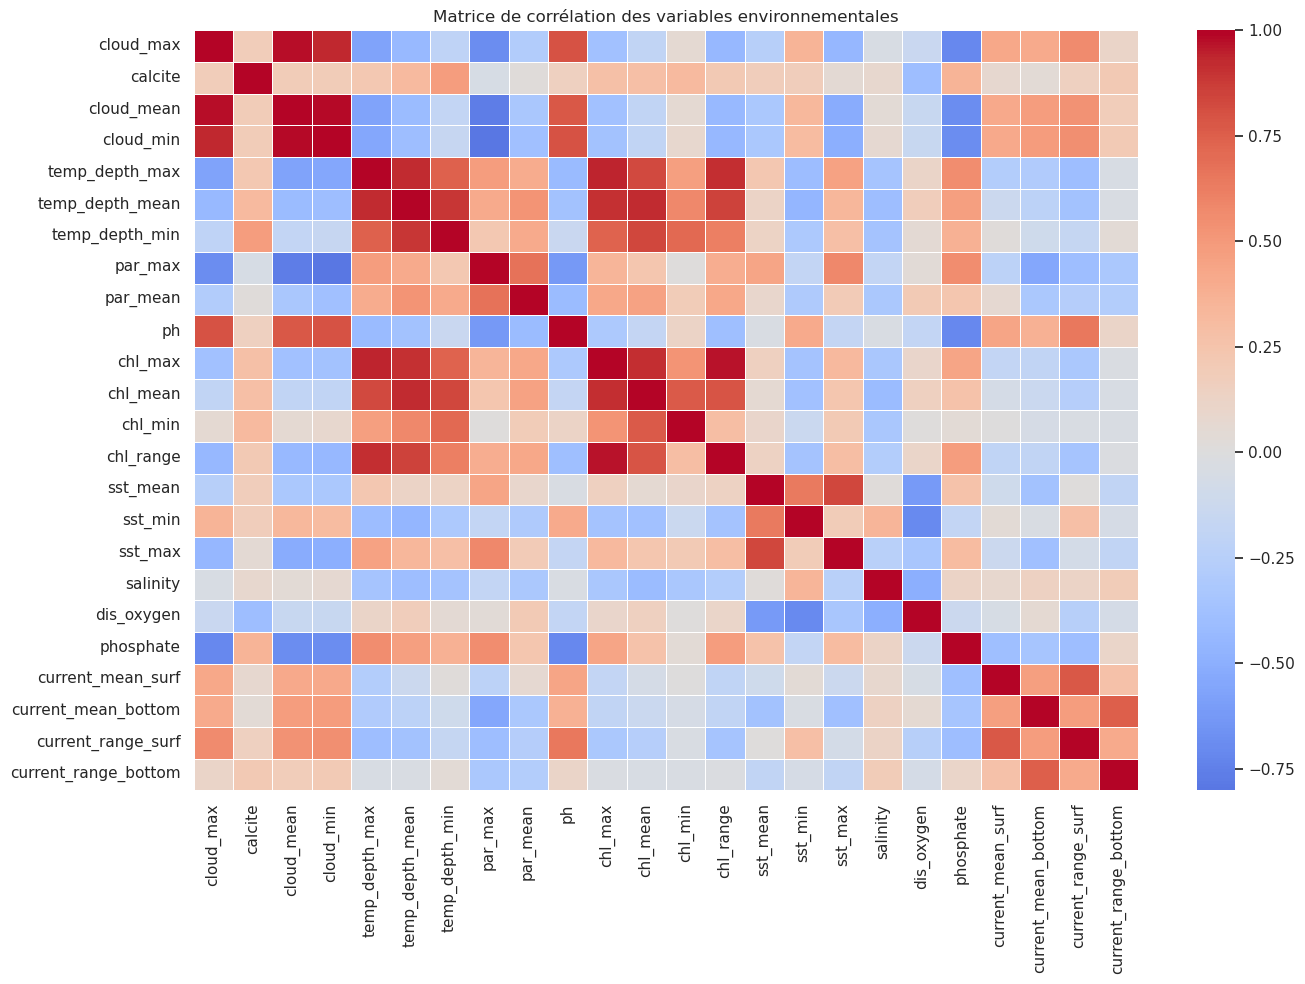

In [17]:
# Matrice de corrélation
corr_matrix = data_corr.corr(method="pearson")

# Visualisation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            cmap="coolwarm", 
            center=0, 
            annot=False, 
            linewidths=0.5)

plt.title("Matrice de corrélation des variables environnementales")

plt.tight_layout()
plt.savefig("/home/francois/Bureau/Projet/Classification/correlation_heatmap.png",
            dpi=300,  # haute résolution pour rapport
            bbox_inches='tight')
plt.show()

## ACP

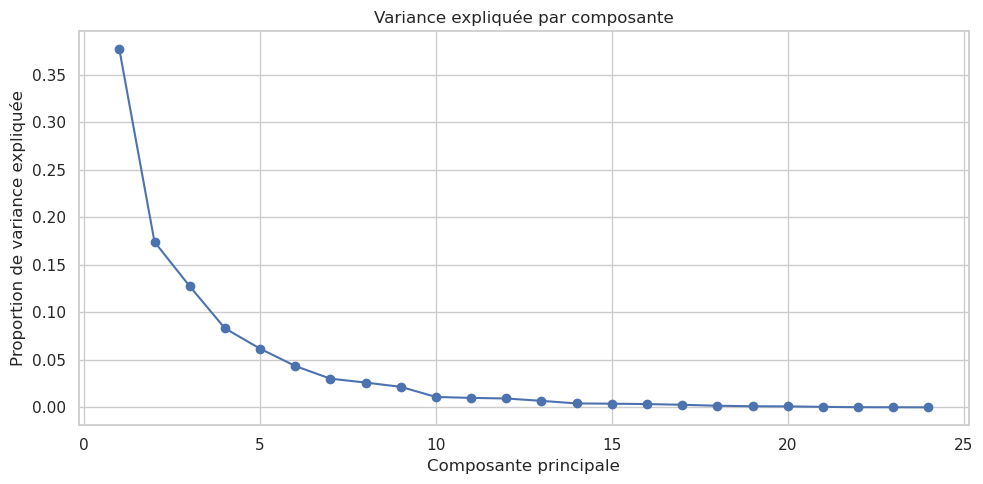

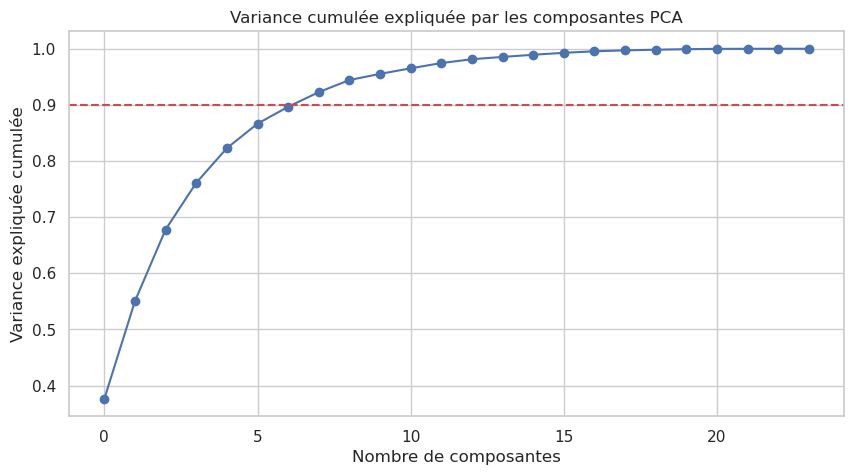

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Variables numériques seulement
X = data_corr.copy()

# Normalisation avant l'ACP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA(n_components=X.shape[1])
pca_fit = pca.fit(X_scaled)

explained = np.cumsum(pca.explained_variance_ratio_)

# Graphes

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, X_scaled.shape[1] + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Composante principale")
plt.ylabel("Proportion de variance expliquée")
plt.title("Variance expliquée par composante")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(explained, marker='o')
plt.axhline(0.90, color='r', linestyle='--')  # ligne 90%
plt.title("Variance cumulée expliquée par les composantes PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.show()



**L’analyse en composantes principales montre que 6 composantes suffisent à expliquer plus de 90 % de la variance totale du jeu de données, ce qui confirme une forte multicolinéarité entre les variables environnementales. Ainsi, la dimensionnalité pourra être réduite efficacement sans perte significative d’information.**

In [19]:
# On récupère les composantes principales du modèle PCA
components = pca.components_

# On récupère le nom des variables d'origine
variable_names = data_corr.columns

# On récupère le nom des axes
pc_names = [f"PC{i+1}" for i in range(components.shape[0])]

# On crée un tableau avec les vecteurs propres
vp = pd.DataFrame(components.T,columns=pc_names, index=variable_names)

# On affiche seulement les 3 premières CPs
vp_3CP = vp.iloc[:, :3]
print(vp_3CP)


                           PC1       PC2       PC3
cloud_max            -0.256389  0.238664 -0.049583
calcite               0.035780  0.223599 -0.272223
cloud_mean           -0.261687  0.250560 -0.026889
cloud_min            -0.261636  0.257585 -0.025993
temp_depth_max        0.299549  0.155189 -0.028699
temp_depth_mean       0.282323  0.239872  0.002408
temp_depth_min        0.214044  0.311028 -0.074662
par_max               0.244101 -0.191040 -0.073755
par_mean              0.191863  0.037816  0.057829
ph                   -0.229634  0.227479 -0.148935
chl_max               0.267990  0.235147 -0.025092
chl_mean              0.233491  0.321556 -0.003841
chl_min               0.118625  0.322128 -0.095716
chl_range             0.265828  0.169321 -0.000082
sst_mean              0.095841 -0.115809 -0.493640
sst_min              -0.141791 -0.093726 -0.441934
sst_max               0.171940 -0.080775 -0.347493
salinity             -0.108750 -0.169358 -0.141091
dis_oxygen            0.054166 

### Interprétation des trois premières composantes principales et sélection des variables

Les trois premières composantes expliquent environ 68 % de la variance totale, ce qui permet déjà d’identifier les principaux gradients environnementaux présents dans l’aire de répartition de la morue.

### Premiere sélection des variables retenues pour la seconde matrice de corrélation (plus lisible)

Certaines variables étaient fortement corrélées entre elles (par exemple min/mean/max d’une même mesure), ce qui entraînait une redondance importante de l’information. On effectue alors notre selection de variables en se basant sur les contributions dans les trois premières composantes principales, ainsi que sur la pertinence écologique de chaque paramètre.

Variables éliminées : Toutes les min et max (on ne garde que les mean).

Ce choix permet de réduire la dimension des données de 27 à 11 variables, tout en conservant l’essentiel de l’information utile à la modélisation de la distribution de la morue.

## Seconde matrice de corrélation (avec lon et lat)


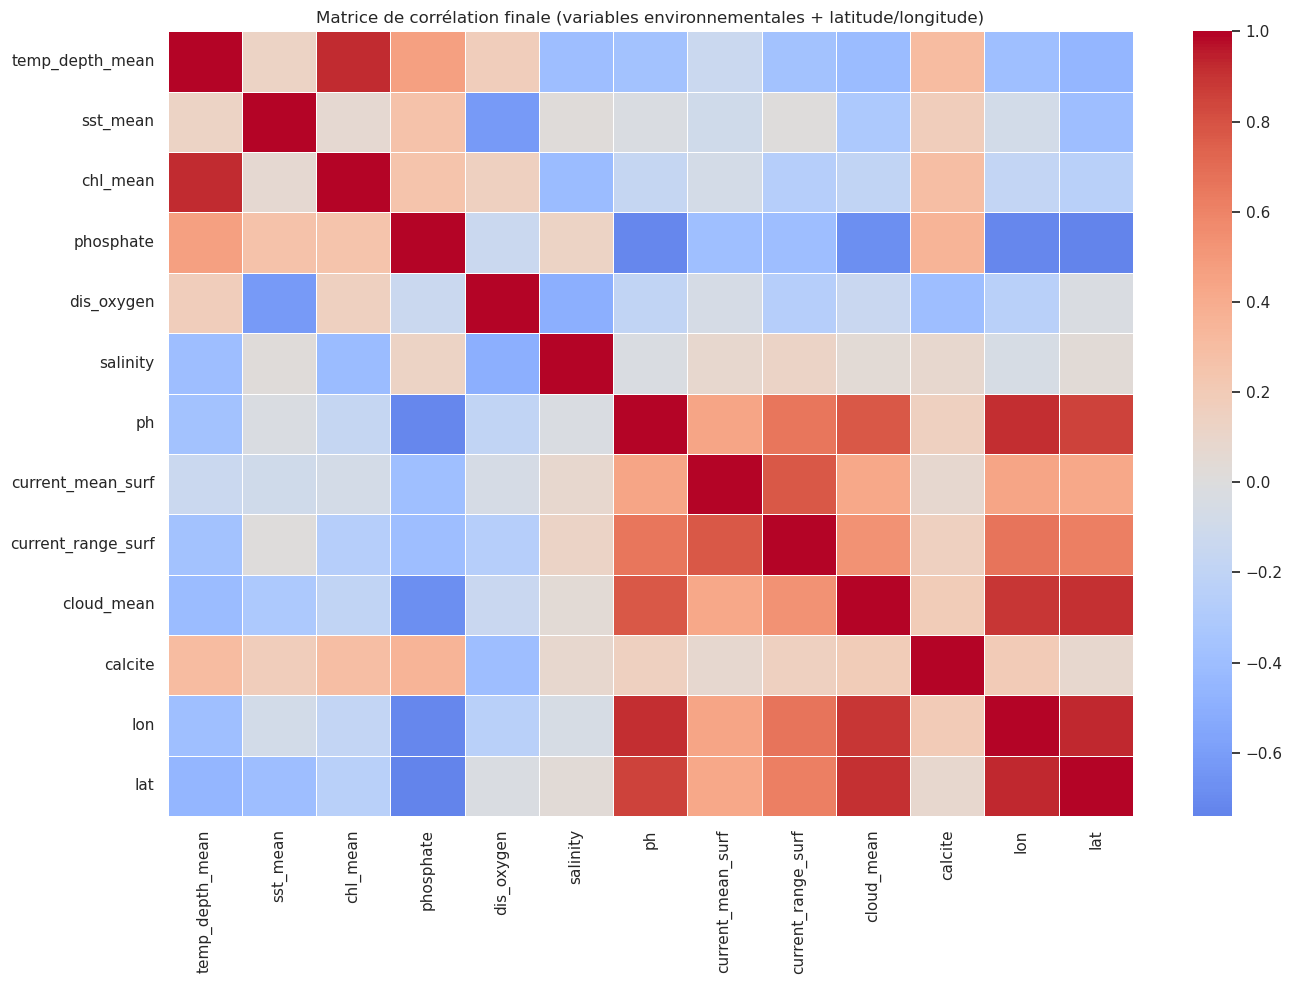

In [20]:
# Matrice de corrélation finale : variables environnementales + latitude/longitude

# Sélectionner les variables environnementales finales + coordonnées géographiques
eco_vars = [
    "temp_depth_mean",
    "sst_mean",
    "chl_mean",
    "phosphate",
    "dis_oxygen",
    "salinity",
    "ph",
    "current_mean_surf",
    "current_range_surf",
    "cloud_mean",
    "calcite"
]

vars_finales= eco_vars + ["lon", "lat"]

data_corr = data[vars_finales].copy()

# Calcul de la matrice de corrélation (Pearson)
corr_matrix = data_corr.corr(method="pearson")

# Visualisation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("Matrice de corrélation finale (variables environnementales + latitude/longitude)")
plt.tight_layout()
plt.show()

**On remarque que certaines variables sont particulièrement corrélées aux coordonnées géographiques (cloud_mean, ph, phosphate(anti-corrélées)), ces variables peuvent biaiser notre apprentissage purement écologique en un apprentissage géographique (risque de fuite de fuite de données spatiales). D'autres, sont corrélées entre elles (chlmean avec temp_depth_mean). Nous les conservont pour le moment mais certaines de ces variables ne seront pas données au modèle dans le prochain notebook.**

In [21]:
# Colonnes finales à conserver pour la table finale mais toute ne seront pas utilisées pour le ML
final_cols = ["lon", "lat", "country", "source", "obs_year"] + eco_vars

# On coupe dans la table
data = data[final_cols].copy()

# Ajoute la cible
data["presence"] = 1

print(" Colonnes finales :", list(data.columns))
print(" Shape :", data.shape)

# Sauvegarde
data.to_csv(
    "/home/francois/Bureau/Projet/Classification/data/gadus_presence.csv",
    index=False
)


 Colonnes finales : ['lon', 'lat', 'country', 'source', 'obs_year', 'temp_depth_mean', 'sst_mean', 'chl_mean', 'phosphate', 'dis_oxygen', 'salinity', 'ph', 'current_mean_surf', 'current_range_surf', 'cloud_mean', 'calcite', 'presence']
 Shape : (9916, 17)


### Sélection finale des variables environnementales

Plusieurs variables semblent fortement colinéaires à la position spatiale: **pH**, **chl_mean** et **cloud_mean** (|r| > 0.85).  
Ces variables traduisent déjà des gradients géographiques (par exemple, température, ensoleillement ou alcalinité liés à la latitude) et risqueraient donc d’introduire un biais(fuite spatiale) si elles étaient combinées aux coordonnées ou aux autres variables fortement corrélées.

Afin d’obtenir un jeu de variables plus indépendant et plus robuste écologiquement, seules les variables décrivant directement les conditions physico-chimiques et dynamiques de l’eau ont été conservées. Ainsi dans le notebook 1, on gardera au début ces 3 variables (au cas où), mais nous entraineront les modèle sans.

## Créations de pseudo-absences avec la méthode du Target group background

Dans notre cas, nous ne disposons **que de données de présence de morue**, sans véritables absences. Le Target Group Background (TGB) est une méthode connue en écologie pour générer ces pseudo-absences de manière moins biaisée.

Principe: Au lieu de placer des absences au hasard dans l’océan, l’idée est de générer les pseudo-absences uniquement là où l’homme a prospecté, c’est-à-dire dans des endroits où d’autres espèces commerciales ont été capturées ou observées à l’aide des mêmes techniques de pêche que pour la morue (principales sources des informations des données de GBIF).

La morue est principalement capturée par des techniques comme le chalut de fond, les filets poissons benthiques, ou parfois les palangres de fond.

Les espèces que nous avons sélectionnées pour le TGB (ici : églefin, lieu noir, merlan, flet et lieu jaune) sont pêchées dans les mêmes zones et avec les mêmes engins de pêche.
Ainsi si une campagne de pêche au chalut a capturé, par exemple, de l’églefin ou du merlan à tel endroit sans capturer de morue, on peut raisonnablement supposer que la morue était absente ou très rare à cet endroit.

Cela permet ainsi de ne pas inventé des points d'absences là ou l'humain n'est jamais allé prospecter dans la période choisie.
On réutilise alors le même biais de collecte pour les présences et les absences ce qui permet d'amoindrir son impact.

Concrètement, nous avons sur R :

- Sélectionné un groupe d’espèces demersales (vivant à proximité du fond mais n’en sont pas dépendantes, impliquant des techniques de pêches similaires) comme la morue.

- Téléchargé leurs présences via GBIF (coordonnées + années récentes).

- Conservé uniquement les points valides (atlantique Nord, année 2023-2025).

- Ajouté, pour chaque point, les variables environnementales issues de Bio-ORACLE.

- Attribué presence = 0 à ces points.

C'est méthode n’est pas parfaite (certains points peuvent contenir de la morue non détectée), mais elle reste la méthode la plus solide pour notre cas.

### Fusion de la table des présences avec celle des pseudo-absences:

In [22]:
# Charger les deux tables
data_p = data.copy()
data_a = pd.read_csv("/home/francois/Bureau/Projet/Classification/data/tgb_background.csv")

# Suppression des colonnes pas utilisées pour le ML
drop_cols = ["country", "source"]
data_p = data_p.drop(columns=drop_cols, errors="ignore")
data_a = data_a.drop(columns=drop_cols, errors="ignore")

# On fait correspondre les colonnes des 2 tables
data_a = data_a[data_p.columns]

cols_p = list(data_p.columns)
cols_a = list(data_a.columns)

print("\n Colonnes présences :")
print(cols_p)

print("\n Colonnes pseudo-absences :")
print(cols_a)

# On regarde s'il n'existe pas de NA mal annotés dans data_a
for col in data_a.columns:
    try:
        data_a[col].astype(float)
    except:
        print(col, "contient des valeurs non-numériques")

# On affiche le nombre de np.nan par variables
missing = data_a.isna().sum().sort_values(ascending=False)
print ("\n Valeurs manquantes dans data_a :")
print(missing)




 Colonnes présences :
['lon', 'lat', 'obs_year', 'temp_depth_mean', 'sst_mean', 'chl_mean', 'phosphate', 'dis_oxygen', 'salinity', 'ph', 'current_mean_surf', 'current_range_surf', 'cloud_mean', 'calcite', 'presence']

 Colonnes pseudo-absences :
['lon', 'lat', 'obs_year', 'temp_depth_mean', 'sst_mean', 'chl_mean', 'phosphate', 'dis_oxygen', 'salinity', 'ph', 'current_mean_surf', 'current_range_surf', 'cloud_mean', 'calcite', 'presence']

 Valeurs manquantes dans data_a :
current_mean_surf     1937
current_range_surf    1937
chl_mean              1930
phosphate             1930
salinity              1930
sst_mean              1930
temp_depth_mean       1930
ph                    1930
cloud_mean            1930
calcite               1930
dis_oxygen            1930
lat                      0
lon                      0
obs_year                 0
presence                 0
dtype: int64


In [23]:
data_a = data_a.dropna()
print(data_a.shape)
print(data_p.shape)

# Fusion Présence (1) + Pseudo-absence (0)
data_final = pd.concat([data_p, data_a], ignore_index=True)

print("\nDataset final fusionné :", data_final.shape)

#On save la table de donnée dans nos fichier
data_final.to_csv(
    "/home/francois/Bureau/Projet/Classification/data/gadus_total.csv",
    index=False
)

# Aperçu
data_final.head()

(12717, 15)
(9916, 15)

Dataset final fusionné : (22633, 15)


,lon,lat,obs_year,temp_depth_mean,sst_mean,chl_mean,phosphate,dis_oxygen,salinity,ph,current_mean_surf,current_range_surf,cloud_mean,calcite,presence
0,-0.819581,54.595220,2025,0.206,10.616,3.550,0.4896,6.419,34.113998,8.183,0.048816,0.031340,0.769,0.003435,1
1,4.100000,51.950000,2025,0.405,12.427,12.789,1.3379,5.685,32.483002,8.207,0.049057,0.138585,0.746,0.018763,1
2,4.100000,51.950000,2025,0.405,12.427,12.789,1.3379,5.685,32.483002,8.207,0.049057,0.138585,0.746,0.018763,1
3,10.385540,63.432354,2025,0.361,8.886,14.717,0.5774,6.981,29.351999,8.210,0.063157,0.128305,0.757,0.001108,1
4,8.349652,63.311088,2025,0.234,9.395,1.982,0.3913,6.906,32.005001,8.176,0.124745,0.213646,0.737,0.000372,1
